<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Specialization "Machine Learning and Data Analysis"
## Capstone project
## 'Users identification'
## Author of the document - Timur Bikmukhametov

In [114]:
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
import itertools
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from collections import OrderedDict, defaultdict, Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
%matplotlib inline

# Introduction

In this project, we will consider an interesting task on user identification based on the data which consists of a sequence of visited web-sites and associated time stamps. The project is divided into 5 parts: __1. Data preparation, 2. Model training, 3. Kaggle competition, 4. Vowpal Wabbit application__ and __5 Conclusions__. Each part considers specific tasks which are useful for any data science project. The specific points about each part are written in the respective parts below. Initially, we have 2 folders with __.csv__ files for __Part 1__ and __Part 2__. One folder consists of the data on 10 users while another one is on 150 users. The data on 10 users is used for initial data preparation and features testing while the data on 150 users is used for testing purposes. As for __Part 3 and Part 4__, the data is provided from __Kaggle__, but the format is similar as in the previous parts. Thus, the data knowledge discoveries from __Part 1__ and __Part 2__ can be extrapolated. Further information is provided in the respective parts below.

# Part 1 - Data preparation

### 1.1 Raw data preparation

We will prepare the data sets for learning within several steps. First, we will split the data into sessions. To do this, we write the function __'prepare_train_set'__ which takes a __".csv"__ file and a wanted session length in and returns a data frame with web-sites numbers in splitted sessions, associated user ids and site frequency dictionary. The code of the function is in __Appendix A__.

We analyse the data from 10 users.

The raw data looks as:

In [14]:
path_to_data = ('C:\Final project data')

In [15]:
data_example = pd.read_csv(os.path.join(path_to_data, '10users/user0031.csv'))
data_example.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


Applying the developed __'prepare_train_set'__ function, we obtain the following training data:

In [16]:
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(path_to_data, '10users'), session_length = 10)
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(path_to_data, '150users'), session_length = 10)

In [17]:
train_data_10users.head()
#site_freq_10users #The frequency dictionary can be also seen here

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,4721,4339,4781,4911,4781,4781,4911,4781,4711,4781,31
1,4490,4722,4217,4659,4781,4883,4513,210,4693,4859,31
2,4859,4911,4859,4859,4909,4619,4490,4577,3999,4859,31
3,4438,431,4438,4859,4859,4859,4859,3953,4714,4790,31
4,4571,4859,4909,1155,4654,4703,912,2672,4218,2672,31


### 1.2 Preparing initial data for classification training

The next step is to use __"bag of words" (or bag of sites in this case)__ approach for classifiction. For this, we make sparse matricies of the previously obtained data frames using developed __"make_sparse"__ function from __Appendix A__.

In [18]:
X_10users, y_10users = train_data_10users.iloc[:, :-1].values, \
                       train_data_10users.iloc[:, -1].values

In [19]:
X_sparse_10users = make_sparse(X_10users)
print 'Shape of sparse matrix is', X_sparse_10users.shape
print 'The resulting sparse matrix is below \n', X_sparse_10users.todense()

Shape of sparse matrix is (14061, 4913)
The resulting sparse matrix is below 
[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


The sparce matrix form is an excellent form for classification task because it shows the frequency of each web-sites in each session. However, to make a better data representation, we introduce a "moving window approach" which will link the sessions and will be used a hyperparameter in the future training procedure. Thus, we make a modification of __"prepare_train_set"__ function and save it as __"prepare_sparse_train_set_window"__ shown in __Appendix A__. Consider a modification of the function with session length of 10 sites and window size of 7 sites. Applying the new fucntion to the data with 10 users, we obtain the following sites and sparse matricies:

In [20]:
X_10users_s10_w7, y_10users_s10_w7 = prepare_sparse_train_set_window(os.path.join(path_to_data, '10users'), 
                                                                     site_freq_path = site_freq_10users, 
                                                                     session_length = 10, window_size = 7, show_matrix = True)

This is the matrix with sites 
[[4721 4339 4781 ... 4781 4711 4781]
 [4781 4711 4781 ... 4781 4883 4513]
 [4781 4883 4513 ... 4911 4859 4859]
 ...
 [4908 4904 4863 ... 4910 4910 4910]
 [4910 4910 4910 ... 4911 4905 4910]
 [4911 4905 4910 ...    0    0    0]]


In [21]:
print 'Shape of sparse matrix is', X_10users_s10_w7.shape
print 'The resulting sparse matrix is below \n', X_10users_s10_w7.todense()

Shape of sparse matrix is (20087, 4913)
The resulting sparse matrix is below 
[[1 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


For futher analysis, let's prepare the training data sets for different values of __session leght__ and __window size__ parameters. The matrix with the required parameters is shown below. This procedure is made for the data with 10 and 150 users.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

In [22]:
%%time

parameters = [(a, b) for a, b in itertools.product([10, 7, 5], [15, 10, 7, 5]) if a <= b]

for num_users in [10, 150]:
    if num_users == 10:
        #for window_size, session_length in tqdm_notebook(parameters): #Run to see iterations
        for window_size, session_length in parameters:
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(path_to_data, str(num_users)+'users'),
                                                      site_freq_path = site_freq_10users,
                                                      session_length=session_length, window_size=window_size, show_matrix = False)

            with open(os.path.join(path_to_data, 'X_sparse_' + str(num_users) + 'users_s' +
                               str(session_length)+'_w' + str(window_size) + '.pkl'), 'wb') as X_sparse_f:
                    pickle.dump(X_sparse, X_sparse_f, protocol=2)
            with open(os.path.join(path_to_data, 'y_' + str(num_users) + 'users_s' +
                               str(session_length)+'_w' + str(window_size) + '.pkl'), 'wb') as y_f:
                    pickle.dump(y, y_f, protocol=2)
    else:
        #for window_size, session_length in tqdm_notebook(parameters): #Run to see iterations
        for window_size, session_length in parameters:
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(path_to_data, str(num_users)+'users'),
                                                      site_freq_path = site_freq_150users,
                                                      session_length=session_length, window_size=window_size, show_matrix = False)
            with open(os.path.join(path_to_data, 'X_sparse_' + str(num_users) + 'users_s' +
                               str(session_length)+'_w' + str(window_size) + '.pkl'), 'wb') as X_sparse_f:
                pickle.dump(X_sparse, X_sparse_f, protocol=2)
            with open(os.path.join(path_to_data, 'y_' + str(num_users) + 'users_s' +
                               str(session_length)+'_w' + str(window_size) + '.pkl'), 'wb') as y_f:
                pickle.dump(y, y_f, protocol=2)

Wall time: 35 s


### 1.3 Preparing additional features for classification training

In order to evaluate the features which can be useful for further training, we need to extract them from the data and make visual analysis. We will create the following features for comparison:
    
Part 1

 - time_diff - time spent for each web-sites in each session (in sec)
 - session_timespan  -  shows the total duration of the session (in sec)
 - #unique_sites - shows number of unique web-sites in each session
 - start_hour - shows the hour at which each session starts
 - day_of_week - shows the day of the week at which the session starts
 
Part 2
 - day_time - shows part of the day at which the sessions starts (morning, afternoon, evening)
 - most_common - shows the most common web-site of the session
 - aver_time - shows the average time spent for 1 web-site in each session (in sec)
 - num_of_top_site - number of session sites from TOP-100 web-sites from all the users
 
__Part 1__ features are implemented in function __prepare_train_set_with_fe__ (Appendix A). __Part 2__ features are implemented in function __feature_engineering__ (Appendix A)

We will evalute the features in the example with 10 users. First, we exctract the Part 1 features followed by Part 2 features.

In [23]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users = prepare_train_set_with_fe(os.path.join(path_to_data, 
                                                         '10users'), 
                  site_freq_path = site_freq_10users,
                  feature_names = feature_names, session_length=10)


Wall time: 5.4 s


In [24]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4721,4339,4781,4911,4781,4781,4911,4781,4711,4781,...,20.0,1.0,0.0,1.0,0.0,33.0,5,8,4,31
1,4490,4722,4217,4659,4781,4883,4513,210,4693,4859,...,0.0,1.0,3.0,3.0,8.0,284.0,10,8,4,31
2,4859,4911,4859,4859,4909,4619,4490,4577,3999,4859,...,0.0,0.0,1.0,0.0,0.0,258.0,7,8,4,31
3,4438,431,4438,4859,4859,4859,4859,3953,4714,4790,...,25.0,1.0,0.0,0.0,0.0,30.0,6,8,4,31
4,4571,4859,4909,1155,4654,4703,912,2672,4218,2672,...,1.0,0.0,1.0,1.0,0.0,6.0,9,8,4,31


In [25]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['day_time', 'most_common', 'aver_time', 'num_of_top_site', 'target']
new_features_10users_2 = feature_engineering(os.path.join(path_to_data, 
                                                         '10users'), 
                  site_freq_path = site_freq_10users, feature_names = feature_names, session_length=10)


Wall time: 8.2 s


In [26]:
new_features_10users_2.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,day_time,most_common,aver_time,num_of_top_site,target
0,4721,4339,4781,4911,4781,4781,4911,4781,4711,4781,0,4781,3.3,2,31
1,4490,4722,4217,4659,4781,4883,4513,210,4693,4859,0,4513,28.4,0,31
2,4859,4911,4859,4859,4909,4619,4490,4577,3999,4859,0,4859,25.8,2,31
3,4438,431,4438,4859,4859,4859,4859,3953,4714,4790,0,4859,3.0,0,31
4,4571,4859,4909,1155,4654,4703,912,2672,4218,2672,0,2672,0.6,1,31


For illustration purposes, let's give a name for each user and associated color.

In [27]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

Let's investigate the __Part 1__ features. The first feature is __session_timespan__.

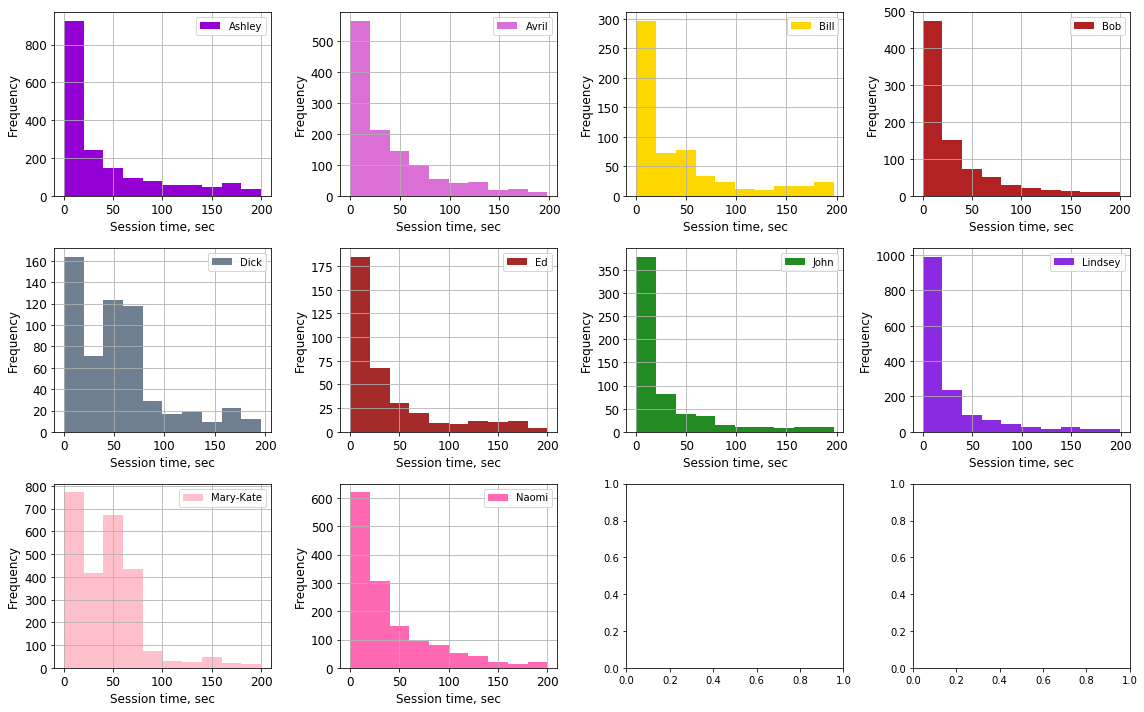

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(pd.groupby(train_data_10users, 'target')):
    i, j = idx / 4, idx % 4
    session_time_hist = sub_df[sub_df['session_timespan'] <= 200]['session_timespan']    
    axes[i, j].hist(session_time_hist, label=user, color=color_dic[user])
    axes[i, j].legend()
    axes[i, j].set_xlabel('Session time, sec', fontsize = 12)
    axes[i, j].set_ylabel('Frequency', fontsize = 12)
    plt.sca(axes[i, j])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

From the plots we see that most of the users have a similar pattern of the time spent for the session. The sessions are usually very short. From this, we can conclude that this feature may not be very representative and can make the predictions even worse. Thus, we will not choose it for further analysis.

The next feature is __number of unique web-sites__.

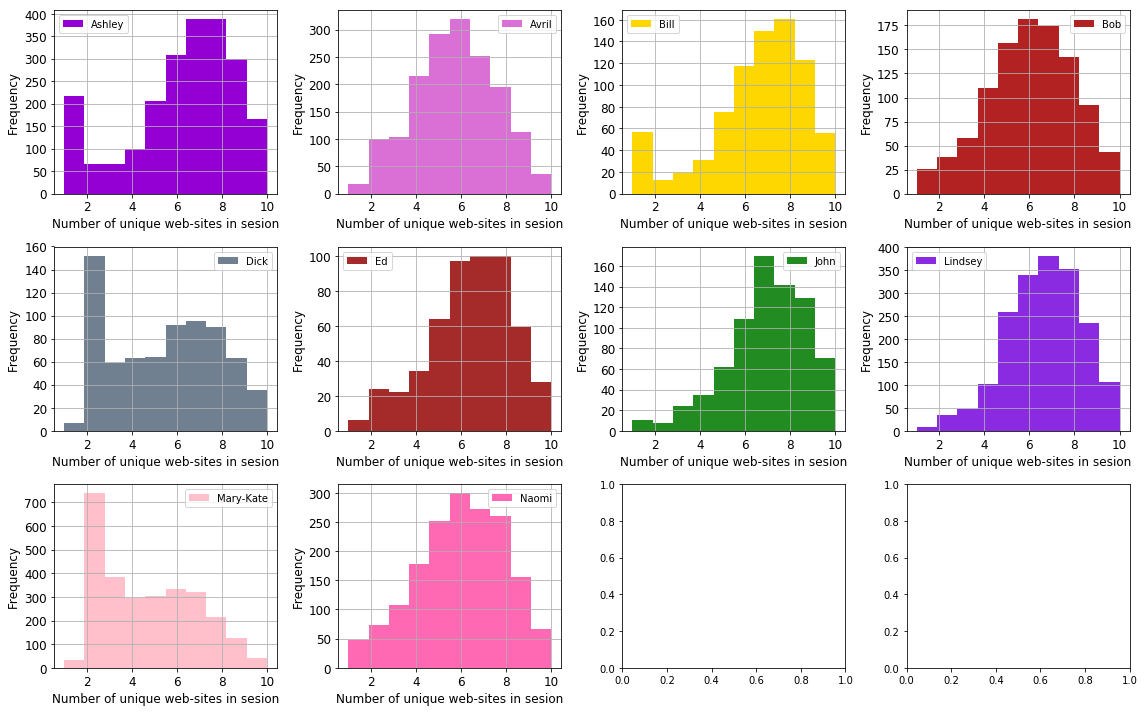

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(pd.groupby(train_data_10users, 'target')):
    i, j = idx / 4, idx % 4
    num_unique_sites_hist = sub_df['#unique_sites']
    axes[i, j].hist(num_unique_sites_hist, label=user, color=color_dic[user])
    axes[i, j].legend()
    axes[i, j].set_xlabel('Number of unique web-sites in sesion', fontsize = 12)
    axes[i, j].set_ylabel('Frequency', fontsize = 12)
    plt.sca(axes[i, j])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

In this case, we again see that the parttern is similar for most of the users. However, to test the hypothesis that this feature will worse the predictions we will keep it for further analysis.

The next feature is __start_hour__.

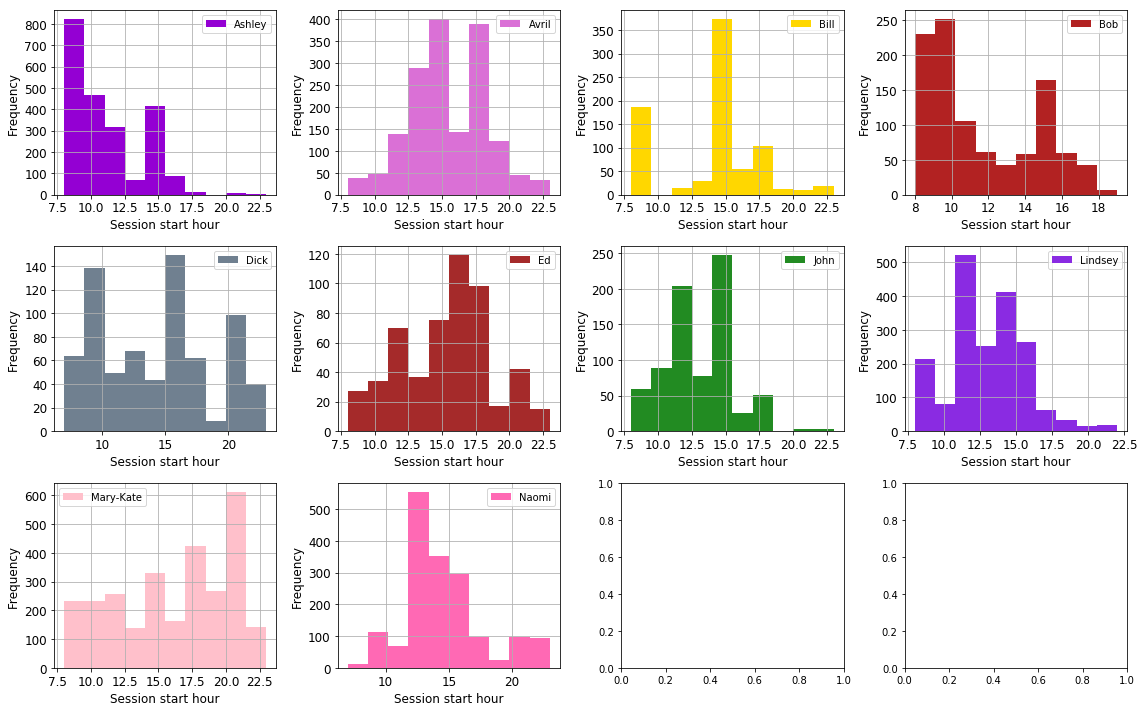

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    i, j = idx // 4, idx % 4
    start_hour_hist = sub_df['start_hour']
    axes[i, j].hist(start_hour_hist, label=user, color=color_dic[user])
    axes[i, j].legend()
    axes[i, j].set_xlabel('Session start hour', fontsize = 12)
    axes[i, j].set_ylabel('Frequency', fontsize = 12)
    plt.sca(axes[i, j])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

From the plots we see that the patterns are very different which makes the feature to be a good one. We surely keep it for further use.

The next feature is __day_of_the_week__.

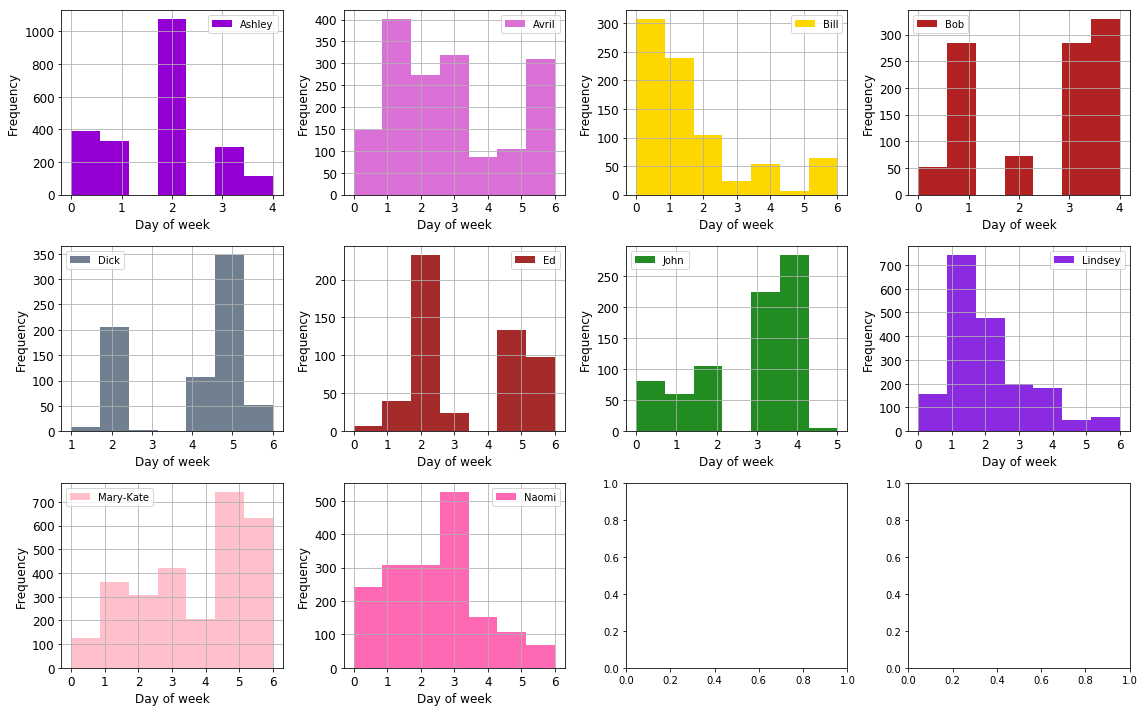

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    i, j = idx // 4, idx % 4
    week_day_hist = sub_df['day_of_week']
    axes[i, j].hist(week_day_hist, label=user, color=color_dic[user], bins = 7)
    axes[i, j].legend()
    axes[i, j].set_xlabel('Day of week', fontsize = 12)
    axes[i, j].set_ylabel('Frequency', fontsize = 12)
    plt.sca(axes[i, j])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

The conclusions about this feature is the same as for the previous one - very representative and will be selected for further use.

Let's consider __Part 2__ features.

In [32]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users_2['target'] = new_features_10users_2['target'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

The first feature is __time_of_the_day__.

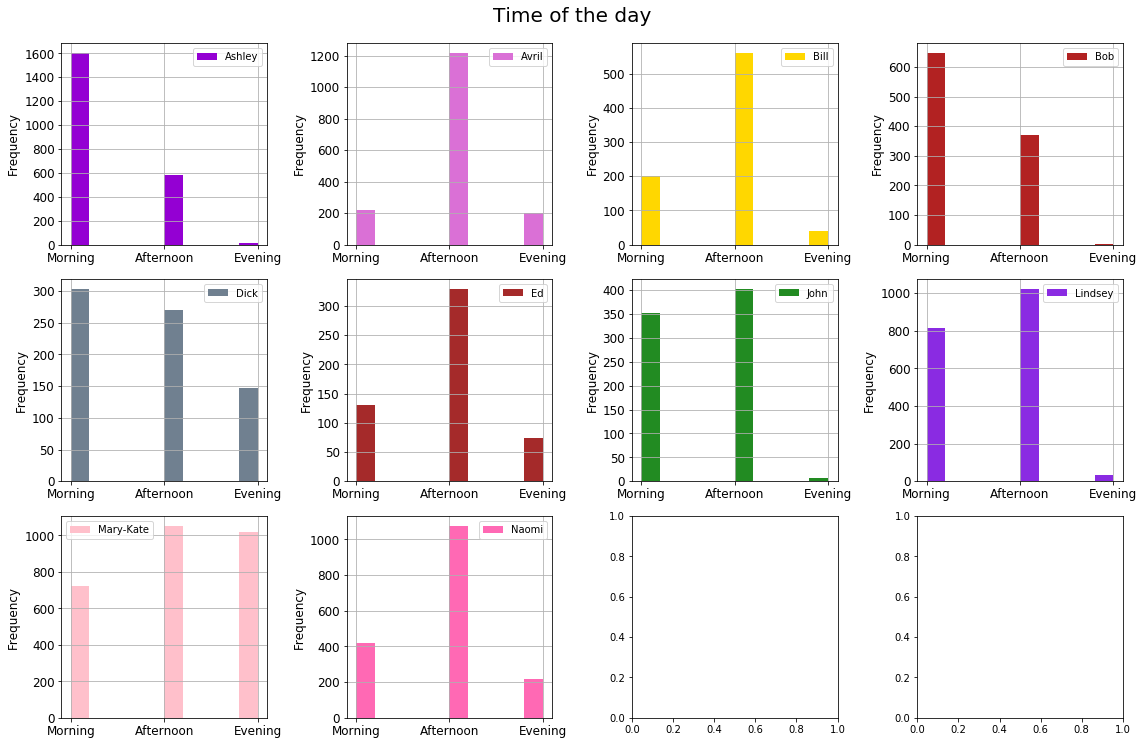

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Time of the day', y = 1.03, fontsize = 20)

for idx, (user, sub_df) in  enumerate(new_features_10users_2.groupby('target')): 
    i, j = idx // 4, idx % 4
    major_ticks = np.arange(0, 3, 1)
    num_unique_sites_hist = sub_df['day_time']
    axes[i, j].hist(num_unique_sites_hist, label=user, color=color_dic[user])
    axes[i, j].legend()
    axes[i, j].set_xticklabels(['Morning', 'Afternoon', 'Evening'])
    axes[i, j].set_ylabel('Frequency', fontsize = 12)
    axes[i, j].set_xticks(major_ticks)
    plt.sca(axes[i, j])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

The feature shows the preferences of the users to use the Internet at different parts of the day. Potentially, this is a good feature since the pattern varies from one user to another.

The next feature is __average_time_for_one_site__.

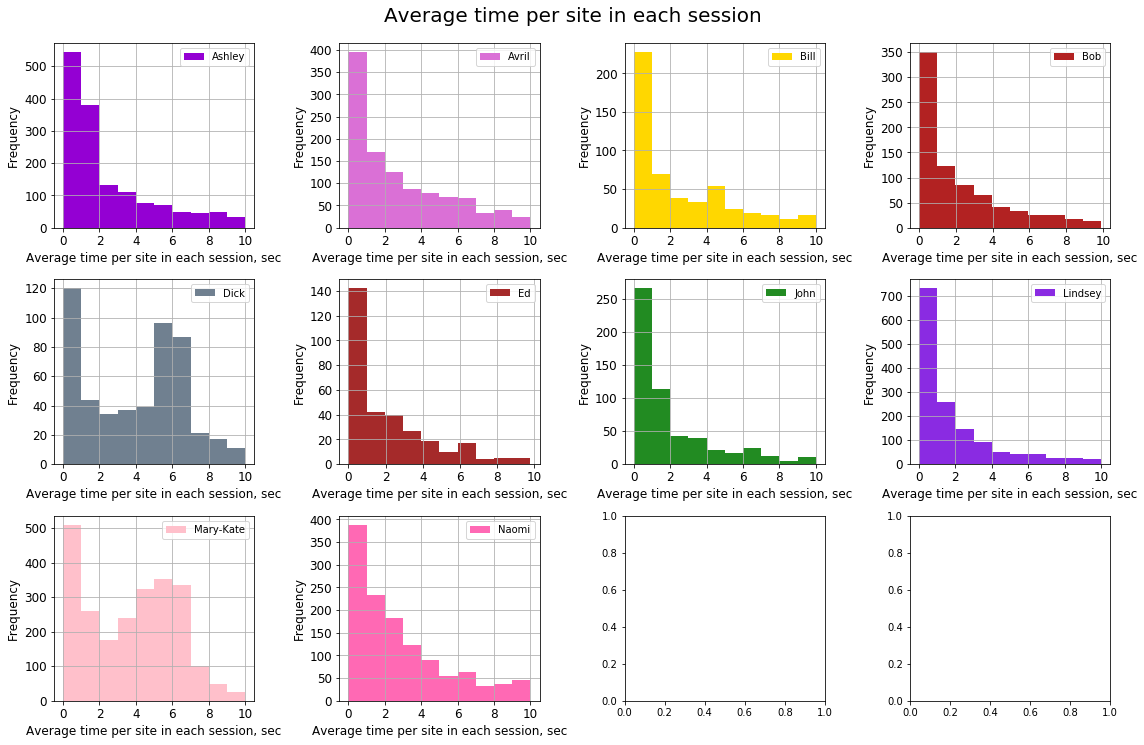

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Average time per site in each session', y = 1.03, fontsize = 20)

for idx, (user, sub_df) in  enumerate(new_features_10users_2.groupby('target')): 
    i, j = idx // 4, idx % 4
    num_unique_sites_hist = sub_df[sub_df['aver_time'] <= 10]['aver_time']
    axes[i, j].hist(num_unique_sites_hist, label=user, color=color_dic[user], bins = 10)
    axes[i, j].legend()
    axes[i, j].set_xlabel('Average time per site in each session, sec', fontsize = 12)
    axes[i, j].set_ylabel('Frequency', fontsize = 12)
    plt.sca(axes[i, j])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

This feautre is very similar to most of the users as it was in __timespance__ feature. We exclude this from further analysis.

The next feature is __most_common_web_site__.

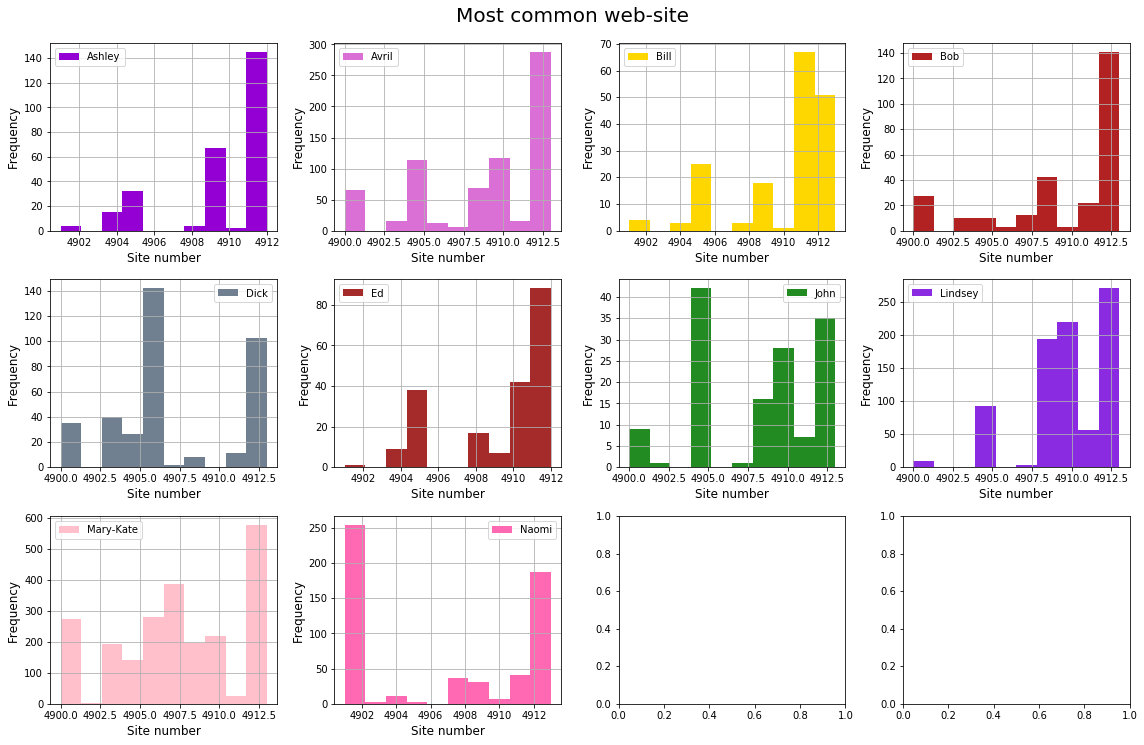

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Most common web-site', y = 1.03, fontsize = 20)

for idx, (user, sub_df) in  enumerate(new_features_10users_2.groupby('target')): 
    i, j = idx // 4, idx % 4
    num_unique_sites_hist = sub_df[sub_df['most_common'] >= 4900]['most_common']
    axes[i, j].hist(num_unique_sites_hist, label=user, color=color_dic[user])
    axes[i, j].legend()
    axes[i, j].set_xlabel('Site number', fontsize = 12)
    axes[i, j].set_ylabel('Frequency', fontsize = 12)
    plt.sca(axes[i, j])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.grid(True)
    plt.tight_layout()

The plots show that the pattern of using the most common web_sites in the sessions is different for the users. This is potentially a good feature.

Finally, consider __TOP_web_site__ feature.

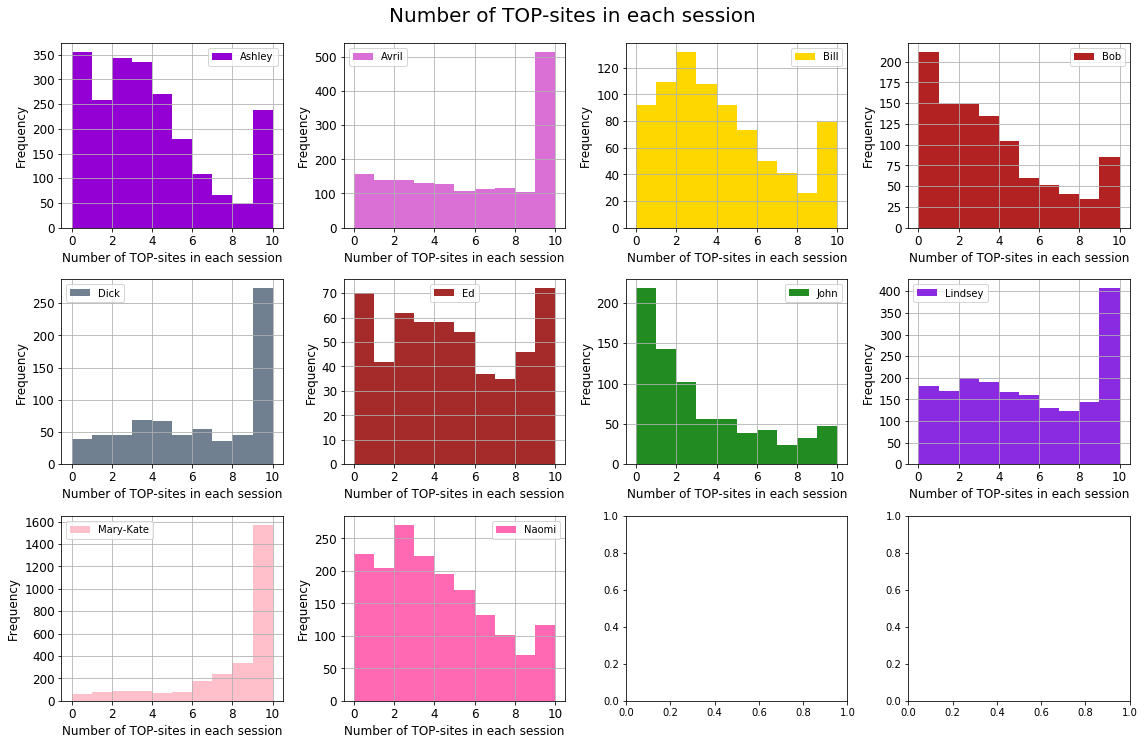

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Number of TOP-sites in each session', y = 1.03, fontsize = 20)

for idx, (user, sub_df) in  enumerate(new_features_10users_2.groupby('target')): 
    i, j = idx // 4, idx % 4
    num_unique_sites_hist = sub_df['num_of_top_site']
    axes[i, j].hist(num_unique_sites_hist, label=user, color=color_dic[user])
    axes[i, j].legend()
    axes[i, j].set_xlabel('Number of TOP-sites in each session', fontsize = 12)
    axes[i, j].set_ylabel('Frequency', fontsize = 12)
    plt.sca(axes[i, j])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

This feature can also be representative, so we will keep for further analysis.

As the result of the visual analysis, we select the following features which we will apply in the future training:
 - #unique_sites
 - start_hour
 - day_of_week
 - day_time
 - most_common
 - num_of_top_site

In [37]:
new_features_10users_def = train_data_10users[['#unique_sites', 'start_hour', 'day_of_week']]
new_features_10users_add = new_features_10users_2[['day_time', 'most_common', 'num_of_top_site']]
selected_features_10users = pd.concat([new_features_10users_def, new_features_10users_add], axis = 1)

# Part 2 - Model training

### 2.1 Classifier selection

As the first step, we need to choose the best algorithm for the data we have. For this purpose, we will use the data with 10 users (__X_sparse_10users__, __y_10users__) obtained in __1.2 section__. First, split the data into the training and validation parts.

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

Then, specify the cross-validation type: 3-fold, shuffled with specific random state. 

In [39]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Also, define a function for plotting validation results.

In [40]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

__We will train the following algorithms:__
 - __KNN__
 - __Random Forest__
 - __Logistic regression__
 - __Linear SVM__

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC

__KNN__

In [42]:
%%time
#Training
knn = KNeighborsClassifier(n_neighbors = 100, n_jobs=-1)
knn.fit(X_train, y_train)
score_train = cross_val_score(knn, X_train, y_train, cv = skf, scoring = 'accuracy')
print 'Mean train score is', score_train.mean()

#Validation
y_pred = knn.predict(X_valid)
score_valid = accuracy_score(y_valid, y_pred)
print 'Validation score is', score_valid

Mean train score is 0.5647188870063362
Validation score is 0.584024650391088
Wall time: 7.86 s


__Random Forest__

In [43]:
%%time
#Training
forest = RandomForestClassifier(n_estimators = 100, random_state=17, oob_score = True, n_jobs = -1)
forest.fit(X_train, y_train)
print 'Out-of-bag score is', forest.oob_score_

#Validation
y_pred = forest.predict(X_valid)
score_valid = accuracy_score(y_valid, y_pred)
print 'Validation score is', score_valid

Out-of-bag score is 0.716521032310506
Validation score is 0.7309789049537805
Wall time: 7.46 s


__Logistic regression__

In [44]:
%%time
logit = LogisticRegression(random_state = 17)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_valid)

print 'Mean train score is', cross_val_score(logit, X_train, y_train, cv = skf, scoring = 'accuracy').mean()
print 'Validation score is', accuracy_score(y_valid, y_pred)

Mean train score is 0.7610267543665875
Validation score is 0.7817018250770325
Wall time: 1.68 s


We also can try to search for a better hyperparameter for the LogistricRegression algorithm. Let's try to choose a better value for C using LogisticRegressionCV.

In [51]:
%%time
logit_c_values1 = np.linspace(0.1, 10, 50)

logit_grid_searcher1 = LogisticRegressionCV(Cs = list(logit_c_values1), multi_class = 'multinomial',  cv= skf, 
                                            scoring = 'accuracy', random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 2min 16s


In [52]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_.values()
Cs = logit_grid_searcher1.Cs
scores = []

for x in logit_mean_cv_scores1:
    for row in x:
        scores.append(row)
        
scores = np.array(scores)
mean_scores = []

for i in range(10):
    mean_scores.append(scores[:, i].mean())    
Cs_and_scores = sorted(zip(Cs, mean_scores), key = lambda x: x[1], reverse = True)
print 'The best C parameter and associated score are', Cs_and_scores[0]

The best C parameter and associated score are (0.9081632653061225, 0.7585892444623035)


Here we see that finding a better C-value than the default one is not straightforward. Though, we can judge the performance of the algorithm more accurately.

__Linear SVM__

In [45]:
%%time
svm = LinearSVC(C=1, random_state = 17)
svm.fit(X_train, y_train)
score_train = cross_val_score(svm, X_train, y_train, cv = skf, scoring = 'accuracy')
y_pred = svm.predict(X_valid)
valid_score = accuracy_score(y_valid, y_pred)

print 'Cross validation score is', score_train.mean()
print 'Validation score is', valid_score

Cross validation score is 0.7527976723012523
Validation score is 0.7769613652524295
Wall time: 4.46 s


We also can try to search for a better hyperparameter for the SVM algorithm. Let's try to choose a better value for __C__ using
__GridSearch__.

In [46]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}
svm_grid_searcher2 = GridSearchCV(svm, svm_params2, scoring = 'accuracy')
svm_grid_searcher2.fit(X_train, y_train)

data_frame_svm_searcher_2 = pd.DataFrame(svm_grid_searcher2.cv_results_)
mean_score = list(data_frame_svm_searcher_2['mean_test_score'])
Cs_param = list(data_frame_svm_searcher_2['param_C'])

best_params = sorted(zip(Cs_param, mean_score), key= lambda x: x[1], reverse = True)
print 'Best searched C value is', best_params[0][0]
print 'Associated test score is', best_params[0][1]

Best searched C value is 0.13879310344827586
Associated test score is 0.766104450315
Wall time: 1min 11s


The plot of the score vs __C__ parameter is shown below.

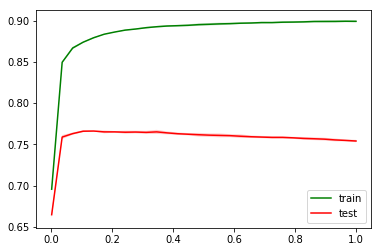

In [47]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Finally, we find the score on the validation sample with the best found __C__ value.

In [48]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
print 'SVM validation score is', svm_cv_acc

SVM validation score is 0.7817018250770325


__Conlcusion__

From the analsysis with testing several algorithms, we see that the LogisticRegression and Linear SVM have approximately the same performance. For further analysis, we choose Linear SVM, however, LinearRegression can also be used.

### 2.2 Hyperparameters tuning

First, we will choose the best combination of the session lenght and window size. For this, we will use the matricies obtained in __1.2 section__. We will evaluate the matricies using the developed function "__model_assesment__" __(Appendix B)__, which takes the matricies in and returns cross-validation score for each matrix.

In [125]:
%%time
estimator = svm_grid_searcher2.best_estimator_

windows = []
ses_lenght = []
train_scores = []
valid_scores = []

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        
        windows.append(window_size)
        ses_lenght.append(session_length)
        
        X_name = 'X_sparse_' + str(10) + 'users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
        y_name = 'y_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_X_pkl = os.path.join(path_to_data, X_name)
        path_to_y_pkl = os.path.join(path_to_data, y_name)
        
        train_score, valid_score = model_assessment(svm_grid_searcher2.best_estimator_, 
                         path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3, path = 'True')
        
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        
windows = pd.DataFrame(windows)
ses_lenght = pd.DataFrame(ses_lenght)
train_score = pd.DataFrame(train_scores)
valid_score = pd.DataFrame(valid_scores)
result = pd.concat([windows, ses_lenght, train_score, valid_score], axis = 1)
result.columns = ['window_size', 'ses_lenght', 'train_score', 'valid_score']

Wall time: 25.8 s


In [70]:
result

,window_size,ses_lenght,train_score,valid_score
0,10,15,0.821790,0.840009
1,10,10,0.763365,0.781702
2,7,15,0.847087,0.854488
3,7,10,0.797585,0.807533
4,7,7,0.754412,0.762900
5,5,15,0.868967,0.876482
6,5,10,0.817957,0.825391
7,5,7,0.775329,0.787103
8,5,5,0.726706,0.736724


__From this analysis, we see that the best combination of the session length and window size is 5 and 15 respectively. Thus, we will use this combination of hyperparameters in further analysis.__

### 2.3 Investigation of additional feature performance

__The next step is to see if the additional features help us to improve the scores. First, we generate the features for the session length of 15 and window size of 5 which were found to be the best choice in the previous section.__

In [109]:
%%time
feature_names = ['site' + str(i) for i in range(1,16)] + \
                ['time_diff' + str(j) for j in range(1,15)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users = prepare_train_set_with_fe(os.path.join(path_to_data, 
                                                         '10users'), 
                  site_freq_path = site_freq_10users,
                  feature_names = feature_names, session_length=15, window_size = 5)

feature_names = ['site' + str(i) for i in range(1,16)] + \
                ['day_time', 'most_common', 'aver_time', 'num_of_top_site', 'target']

new_features_10users_2 = feature_engineering(os.path.join(path_to_data, 
                                                         '10users'), 
                  site_freq_path=site_freq_10users, feature_names = feature_names, 
                                             session_length=15, window_size = 5)

new_features_10users_def = train_data_10users[['#unique_sites', 'start_hour', 'day_of_week']]
new_features_10users_add = new_features_10users_2[['day_time', 'most_common', 'num_of_top_site']]
selected_features_10users = pd.concat([new_features_10users_def, new_features_10users_add], axis = 1)


Wall time: 22.3 s


__Then, we train the agorithm adding one feature at each iteration__.

In [135]:
%%time
with open(os.path.join(path_to_data, 'X_sparse_10users_s15_w5.pkl'), 'rb') as f:
        X_train = pickle.load(f)

with open(os.path.join(path_to_data, 'y_10users_s15_w5.pkl'), 'rb') as f:
        y = pickle.load(f)

train_scores = [0.868967]
valid_scores = [0.876482]
feature = ['default']

for column in selected_features_10users:
    feature.append(column)
    sparce_column = csr_matrix(np.array(selected_features_10users[column]).reshape((selected_features_10users.shape[0],1)))
    X_total = sp.hstack((X_train, sparce_column))
    X_total = csr_matrix(X_total)
    
    train_score, valid_score = model_assessment(svm_grid_searcher2.best_estimator_, 
    X_total, y, skf, random_state=17, test_size=0.3, path = 'False')  
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    

train_score = pd.DataFrame(train_scores)
valid_score = pd.DataFrame(valid_scores)
feature = pd.DataFrame(feature)

result = pd.concat([feature, train_score, valid_score], axis = 1)
result.columns = ['feature', 'train_score', 'valid_score']

Wall time: 1min 21s


In [136]:
result

,feature,train_score,valid_score
0,default,0.868967,0.876482
1,#unique_sites,0.869272,0.877074
2,start_hour,0.874657,0.884305
3,day_of_week,0.871558,0.878615
4,day_time,0.874657,0.883950
5,most_common,0.283910,0.112613
6,num_of_top_site,0.868967,0.876482


__From the obtained results we see that adding features separately can slightly improve the scores. At the same time, the feature representing the most common web-site totally destroys the predictions. The next step is to see how the combination of the best features can improve the scores__. __Let's compare how the algorithm works if we add day_time_ and _start_hour_ features at the same time__.

In [142]:
%%time
train_scores = [0.868967]
valid_scores = [0.876482]
feature = ['default', 'day_time + start_hour']

sparce_column = csr_matrix(np.array(selected_features_10users[['day_time', 'start_hour']]).reshape((selected_features_10users.shape[0],2)))
X_total = sp.hstack((X_train, sparce_column))
X_total = csr_matrix(X_total)
    
train_score, valid_score = model_assessment(svm_grid_searcher2.best_estimator_, 
X_total, y, skf, random_state=17, test_size=0.3, path = 'False')  
train_scores.append(train_score)
valid_scores.append(valid_score)
    

train_score = pd.DataFrame(train_scores)
valid_score = pd.DataFrame(valid_scores)
feature = pd.DataFrame(feature)

result = pd.concat([feature, train_score, valid_score], axis = 1)
result.columns = ['feature', 'train_score', 'valid_score']

Wall time: 10.4 s


In [143]:
result

,feature,train_score,valid_score
0,default,0.868967,0.876482
1,day_time + start_hour,0.875166,0.885135


__From this, we clearly see that adding two features at the same time improves the scores even more. Now, we can apply the selected parameters and features for the data set with 150 users to see the ffect on a larger data set.__ __First, we generate the features and then apply the same proceduare as before__.

In [49]:
%%time
feature_names = ['site' + str(i) for i in range(1,16)] + \
                ['time_diff' + str(j) for j in range(1,15)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_150users = prepare_train_set_with_fe(os.path.join(path_to_data, 
                                                         '150users'), 
                  site_freq_path = site_freq_150users,
                  feature_names = feature_names, session_length=15, window_size = 5)

feature_names = ['site' + str(i) for i in range(1,16)] + \
                ['day_time', 'most_common', 'aver_time', 'num_of_top_site', 'target']

new_features_150users_2 = feature_engineering(os.path.join(path_to_data, 
                                                         '150users'), 
                  site_freq_path = site_freq_150users, feature_names = feature_names, 
                                             session_length=15, window_size = 5)

new_features_150users_def = train_data_150users[['#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users_add = new_features_150users_2[['day_time', 'most_common', 'num_of_top_site']]
selected_features_150users = pd.concat([new_features_150users_def, new_features_150users_add], axis = 1)


Wall time: 3min 43s


In [50]:
%%time

with open(os.path.join(path_to_data, 'X_sparse_150users_s15_w5.pkl'), 'rb') as f:
        X_train = pickle.load(f)

with open(os.path.join(path_to_data, 'y_150users_s15_w5.pkl'), 'rb') as f:
        y = pickle.load(f)

train_scores = []
valid_scores = []
feature = ['default', 'day_time + start_hour']

#Train the default algorithm
train_score, valid_score = model_assessment(svm_grid_searcher2.best_estimator_, 
X_train, y, skf, random_state=17, test_size=0.3, path = 'False')     
train_scores.append(train_score)
valid_scores.append(valid_score)

#Train the algorithm with additonal features
sparce_column = csr_matrix(np.array(selected_features_150users[['day_time', 'start_hour']]).reshape((selected_features_150users.shape[0],2)))
X_total = sp.hstack((X_train, sparce_column))
X_total = csr_matrix(X_total)
train_score, valid_score = model_assessment(svm_grid_searcher2.best_estimator_, 
X_total, y, skf, random_state=17, test_size=0.3, path = 'False')  
train_scores.append(train_score)
valid_scores.append(valid_score)

#Writing the results
train_score = pd.DataFrame(train_scores)
valid_score = pd.DataFrame(valid_scores)
feature = pd.DataFrame(feature)

result = pd.concat([feature, train_score, valid_score], axis = 1)
result.columns = ['feature', 'train_score', 'valid_score']

Wall time: 1h 4min 55s


In [51]:
result

,feature,train_score,valid_score
0,default,0.616775,0.639193
1,day_time + start_hour,0.629702,0.652346


__Here we see that the new features also improve the scores. At the same time, we see that the algorithm works less accurate than for 10 users.__

### 2.4 Conclusions

we conclude that additional features definitely improve the scores, however, the features must be selected carefully and be represntaive which means have different patterns for as many users as possible. Further imporvements can be made by performing a deeper analsysis of features as well as more extensive parameters selection.__

# Part 3 - Kaggle competition

In this part, we will use the skills, knowledge and the basis of the developed functions for participating in Kaggle competiton. The link to the competition is [here](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The main goal is to identify a specific user, Alice, from the given data. We will use __SGDClassifier__ as a faster alternative of __Linear SVM__ which we used in the previous part.

### 3.1 Data preprocessing

First, we read the data.

In [52]:
train_df = pd.read_csv(os.path.join(path_to_data, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=[0])
test_df = pd.read_csv(os.path.join(path_to_data, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=[0])

In [53]:
print 'The shape of the training set is', train_df.shape
train_df.head()

The shape of the training set is (253561, 21)


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


For making the total sparce matrix, we merge the training and test matricies.

In [54]:
train_test_df = pd.concat([train_df, test_df])

Also, we look at the target class staistics.

In [55]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

From this we see highly imbalanced classes, so the accuracy metric may be not be very representative in this case.

For initial model training, we make the fill the __Na__ values with zeros, make the sparce matrix and then split into training and test parts.

In [56]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [57]:
%%time
train_test_sparse = make_sparse(train_test_df_sites)
X_train_sparse = train_test_sparse[:train_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
y = train_df['target']

Wall time: 2.22 s


Split the training matrix intro the training and valiadation parts.

In [58]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

### 3.2 Default model training

__First, we train SGDClassifier with logistic loss function to see the "default" score we can add without adding any other features__

In [61]:
%%time
sgd_logit = SGDClassifier(loss = 'log', random_state=17, n_jobs = -1)
sgd_logit.fit(X_train, y_train)

Wall time: 251 ms


Let's check the ROC AUC scores in the validation sample.

In [64]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
roc_auc_score(y_valid,logit_valid_pred_proba[:,1])

0.933847286790615

These prediction give us __0.91273__ score on Kaggle. We will use this as the default barrier which we want to beat.

### 3.2 Additional feature extraction

We will exctract the features which we used before in the analysis to compare if they make any sense in this data set. Since the form of the data is different as we had before, a new function is developed named __features_extraction__ __(Appendix C)__ to discover the features from the given data set.

Before that, we make a dictionary of the sits with its number and frequency for the given data set.

In [66]:
%%time
data_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
all_sites = []
for i, row in data_sites.iterrows():
    for site in row:
        if site == 0:
            pass
        else:
            all_sites.append(site)
sites_dict = Counter(all_sites)

Wall time: 18.1 s


In [80]:
%%time
feats = features_extraction(train_df)

Wall time: 21.1 s


We merge the data and obtained features in one data frame.

In [81]:
data_sites = train_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
data_sites.index = range(0, 253561)
target = train_df['target']
target.index = range(0, 253561)
total_data = pd.concat([data_sites, feats, target], axis = 1)
total_data.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,week_day,start_hour,day_time,unique_sites,total_min_diff,month_array,target
0,718,0,0,0,0,0,0,0,0,0,3,10,0,1,30,2,0
1,890,941,3847,941,942,3846,3847,3846,1516,1518,5,11,0,7,1,2,0
2,14769,39,14768,14769,37,39,14768,14768,14768,14768,0,16,1,4,0,12,0
3,782,782,782,782,782,782,782,782,782,782,4,10,0,1,4,3,0
4,22,177,175,178,177,178,175,177,177,178,4,10,0,4,4,2,0


As we can see, we also added __total_min_diff__ which denotes the total minutes spent for the session. For visual analysis, we split the data into Alice and Non-Alice parts.

In [82]:
alice_data = total_data[total_data['target'] == 1]
non_alice_data = total_data[total_data['target'] == 0]

__Let's plot the features. First feature is week day__.

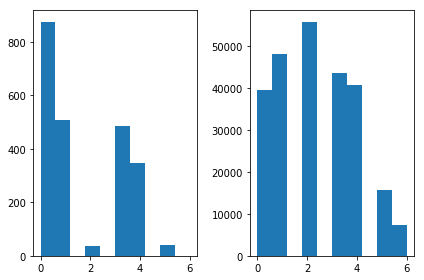

In [83]:
plt.subplot(1,2,1)
plt.hist(alice_data['week_day'])
plt.subplot(1,2,2)
plt.hist(non_alice_data['week_day'])
plt.tight_layout()

__Next is starting hour__

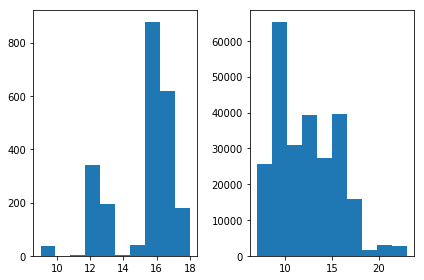

In [84]:
plt.subplot(1,2,1)
plt.hist(alice_data['start_hour'])
plt.subplot(1,2,2)
plt.hist(non_alice_data['start_hour'])
plt.tight_layout()

__Unique web-sites__

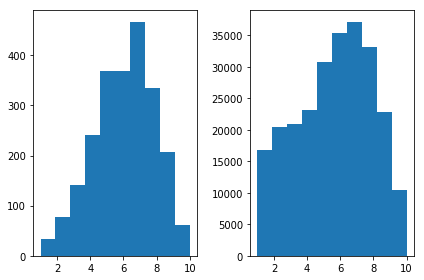

In [85]:
plt.subplot(1,2,1)
plt.hist(alice_data['unique_sites'])
plt.subplot(1,2,2)
plt.hist(non_alice_data['unique_sites'])
plt.tight_layout()

__Day_time__

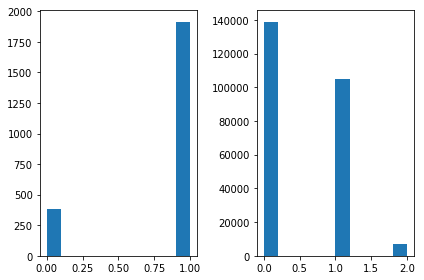

In [86]:
plt.subplot(1,2,1)
plt.hist(alice_data['day_time'])
plt.subplot(1,2,2)
plt.hist(non_alice_data['day_time'])
plt.tight_layout()

__Total minutes difference__

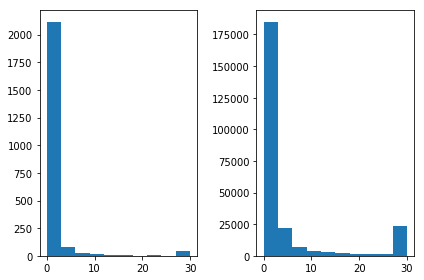

In [87]:
plt.subplot(1,2,1)
plt.hist(alice_data[alice_data['total_min_diff'] < 50]['total_min_diff'])
plt.subplot(1,2,2)
plt.hist(non_alice_data[non_alice_data['total_min_diff'] < 50]['total_min_diff'])
plt.tight_layout()

__Starting month__

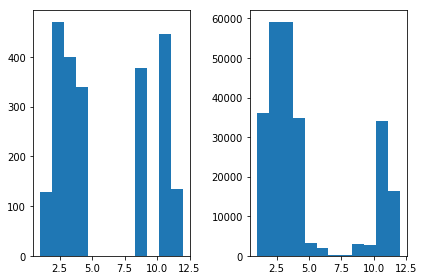

In [88]:
plt.subplot(1,2,1)
plt.hist(alice_data['month_array'], bins = 12)
plt.subplot(1,2,2)
plt.hist(non_alice_data['month_array'], bins = 12)
plt.tight_layout()

__Discussion__

From the analysis, we can see that potentially __start_hour__ and __day_of_week__ can be useful features because we can see quite different patterns for Alice and Non-Alice users. Let's train the algorithm for each additonal feature and see if the hypothesis is correct and we get any help from the additonal features.

In [89]:
feats = features_extraction(train_test_df)

In [97]:
%%time

auc_score = [0.934]
feature = ['default']


for column in feats:
    feature.append(column)
    sparce_column = csr_matrix(np.array(feats[column]).reshape((feats.shape[0],1)))
    X_total = sp.hstack((train_test_sparse, sparce_column))
    X_total = csr_matrix(X_total)
    X_train_sparse = X_total[:train_df.shape[0], :]
    X_test_sparse = X_total[train_df.shape[0]:, :]
    y = train_df['target']
    train_share = int(.7 * X_train_sparse.shape[0])
    X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
    X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]
    
    #Training
    sgd_logit = SGDClassifier(loss = 'log', learning_rate='optimal', random_state=17, n_jobs = -1)
    sgd_logit.fit(X_train, y_train)
    logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
    auc_score.append(roc_auc_score(y_valid, logit_valid_pred_proba[:,1]))


auc_score = pd.DataFrame(auc_score)
feature = pd.DataFrame(feature)

result = pd.concat([feature, auc_score], axis = 1)
result.columns = ['feature', 'auc_score']

Wall time: 2.3 s


In [98]:
result

,feature,auc_score
0,default,0.934000
1,week_day,0.924717
2,start_hour,0.890104
3,day_time,0.936187
4,unique_sites,0.921548
5,total_min_diff,0.919726
6,month_array,0.921540


From the result we see that only __day_time__ feature improves the score. The second best is __week_day__. Let's check how these two perform together.

In [99]:
%%time

auc_score = [0.934]
feature = ['default','day_time + week_day']

sparce_column = csr_matrix(np.array(feats[['day_time', 'week_day']]).reshape((feats.shape[0], 2)))
X_total = sp.hstack((train_test_sparse, sparce_column))
X_total = csr_matrix(X_total)
X_train_sparse = X_total[:train_df.shape[0], :]
X_test_sparse = X_total[train_df.shape[0]:, :]
y = train_df['target']
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]
    
#Training
sgd_logit = SGDClassifier(loss = 'log', learning_rate='optimal', random_state=17, n_jobs = -1)
sgd_logit.fit(X_train, y_train)
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
auc_score.append(roc_auc_score(y_valid, logit_valid_pred_proba[:,1]))


auc_score = pd.DataFrame(auc_score)
feature = pd.DataFrame(feature)

result = pd.concat([feature, auc_score], axis = 1)
result.columns = ['feature', 'auc_score']

Wall time: 421 ms


In [100]:
result

,feature,auc_score
0,default,0.934000
1,day_time + week_day,0.924463


We see that the combination does not improve the core for the validation sample, but we will keep it for the submission to checkif this is correct.

The next step is to try finding a better hyperparametre, for example, __alpha__. We will do it with __GridSearch__ method.

In [102]:
%%time
alphas = {'alpha': np.linspace(0.00001, 0.0001, 100)}
sgd_logit = SGDClassifier(loss = 'log', random_state=17, n_jobs = -1)
svm_grid_searcher2 = GridSearchCV(sgd_logit ,param_grid = alphas)
svm_grid_searcher2.fit(X_train_sparse, y)

Wall time: 1min 36s


In [103]:
svm_grid_searcher2.best_params_

{'alpha': 4e-05}

Let's test the best parameter for two cases: with __day_time__ feature and __day_time + week_day__

In [108]:
%%time

auc_score = [0.934]
feature = ['default','day_time']

sparce_column = csr_matrix(np.array(feats[['day_time']]).reshape((feats.shape[0], 1)))
X_total = sp.hstack((train_test_sparse, sparce_column))
X_total = csr_matrix(X_total)
X_train_sparse = X_total[:train_df.shape[0], :]
X_test_sparse = X_total[train_df.shape[0]:, :]
y = train_df['target']
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]
    
#Training
sgd_logit = SGDClassifier(loss = 'log', learning_rate='optimal', random_state=17, n_jobs = -1, alpha = 4e-05)
sgd_logit.fit(X_train, y_train)
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
auc_score.append(roc_auc_score(y_valid, logit_valid_pred_proba[:,1]))


auc_score = pd.DataFrame(auc_score)
feature = pd.DataFrame(feature)

result = pd.concat([feature, auc_score], axis = 1)
result.columns = ['feature', 'auc_score']

Wall time: 369 ms


In [105]:
result

,feature,auc_score
0,default,0.934000
1,day_time,0.949478


In [106]:
%%time

auc_score = [0.934]
feature = ['default','day_time + week_day']

sparce_column = csr_matrix(np.array(feats[['day_time', 'week_day']]).reshape((feats.shape[0], 2)))
X_total = sp.hstack((train_test_sparse, sparce_column))
X_total = csr_matrix(X_total)
X_train_sparse = X_total[:train_df.shape[0], :]
X_test_sparse = X_total[train_df.shape[0]:, :]
y = train_df['target']
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]
    
#Training
sgd_logit = SGDClassifier(loss = 'log', learning_rate='optimal', random_state=17, n_jobs = -1, alpha = 4e-05)
sgd_logit.fit(X_train, y_train)
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
auc_score.append(roc_auc_score(y_valid, logit_valid_pred_proba[:,1]))


auc_score = pd.DataFrame(auc_score)
feature = pd.DataFrame(feature)

result = pd.concat([feature, auc_score], axis = 1)
result.columns = ['feature', 'auc_score']

Wall time: 422 ms


In [107]:
result

,feature,auc_score
0,default,0.934000
1,day_time + week_day,0.947922


__We see that tuning alpha significantly improved the results. When the predictions for these two cases are submitted, the following scores are obtained__

 - default  + day_time: __0.91520__ 
 - default + day_time + week_day: __0.93124__

__As we can see, on the test set, two features performed better even though on the validation set, one additional feature was preferable.__

### 3.4 Conclusions

We participated in Kaggle competion on identifying a user based on the given data about the web-sites and time stamps. First, SGDClassifer was fitted with defaiult settings and site features. Afterwards, seprate features were added to the training set and tested. Also, hyperparameter searched was perfromed. As the result, the default score was overperformed and the final score is __0.93124__. This can be found under the name __[YDF & MIPT] Timur Bikmukhametov__ on the leaderboard.

# Part 4 - Vowpal Wabbit application

In this part, we will apply Vowpal Wabbit library for user identification based on another Kaggle competition which you can find [here](https://inclass.kaggle.com/c/identify-me-if-you-can4/data).

### 4.1 Data preprocessing

First, we download the data.

In [116]:
train_df_400 = pd.read_csv(os.path.join(path_to_data,'train_sessions_400users.csv'), 
                           index_col='session_id')

In [117]:
test_df_400 = pd.read_csv(os.path.join(path_to_data,'test_sessions_400users.csv'), 
                           index_col='session_id')

In [118]:
train_df_400.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,...,2014-03-24 15:22:55,23713.0,2014-03-24 15:23:01,23713.0,2014-03-24 15:23:03,23713.0,2014-03-24 15:23:04,23713.0,2014-03-24 15:23:05,653
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,...,2014-04-17 14:26:01,45.0,2014-04-17 14:26:01,5320.0,2014-04-17 14:26:18,5320.0,2014-04-17 14:26:47,5320.0,2014-04-17 14:26:48,198
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,...,2014-03-21 10:13:36,303.0,2014-03-21 10:13:54,309.0,2014-03-21 10:14:01,303.0,2014-03-21 10:14:06,303.0,2014-03-21 10:14:24,34
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,...,2013-12-13 09:54:34,1346.0,2013-12-13 09:54:34,1345.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:58:19,1345.0,2013-12-13 09:58:19,601
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,...,2013-11-26 12:35:32,11.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:03,10.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:04,273


To apply Vowpal Wabbit, we need to label the classes within the range 1 - K, where K - the number of classes. We do that using __LabelEncoder__.

In [119]:
y = train_df_400['user_id']
class_encoder = LabelEncoder()
y_for_vw = class_encoder.fit_transform(y) + 1

We will comapre __VW__ results with __SGDClassifier__ and __LogisticRegressor__. Before that, we need to preprocess the data as we didi before. This time the procedure is similar.

In [122]:
sites = ['site' + str(i) for i in range(1, 11)]

In [123]:
train_test_df = pd.concat([train_df_400, test_df_400], axis = 0)
train_test_df_sites = train_test_df[sites].fillna(0).astype(int)

In [124]:
%%time
X_sparse_data = make_sparse(train_test_df_sites)
X_train_sparse = X_sparse_data[:train_df_400.shape[0], :]
X_test_sparse = X_sparse_data[train_df_400.shape[0]:, :]
y = y_for_vw

print X_train_sparse.shape
print X_test_sparse.shape
print y.shape

(182793, 36656)
(46473, 36656)
(182793L,)
Wall time: 1.52 s


__Then, we need to split the data into training and validation parts__.

In [125]:
train_df = train_df_400[sites].fillna(0).astype(int)
test_df = test_df_400[sites].fillna(0).astype(int)

In [126]:
train_share = int(.7 * train_df_400.shape[0])
train_df_part = train_df_400[sites].iloc[:train_share, :].fillna(0).astype(int)
valid_df = train_df_400[sites].iloc[train_share:, :].fillna(0).astype(int)
X_train_part_sparse = X_train_sparse[:train_share, :]
X_valid_sparse = X_train_sparse[train_share:, :]

In [127]:
y_train_part = y[:train_share]
y_valid = y[train_share:]
y_train_part_for_vw = y_for_vw[:train_share]
y_valid_for_vw = y_for_vw[train_share:]

Then, we need to trainform the data into the VW-like format. We do this with __arrays_to_vw__ function from __Appendix D.__

In [131]:
%%time
arrays_to_vw(train_df_part.values, y = y_train_part_for_vw, out_file = 'train_part.vw')
arrays_to_vw(valid_df.values, y = y_valid_for_vw, out_file = 'valid.vw')
arrays_to_vw(train_df.values, y = y_for_vw, out_file = 'train.vw')
arrays_to_vw(test_df.values, out_file = 'test.vw')

Wall time: 2.94 s


An example of the VW format data is below.

In [132]:
VW_format = open(os.path.join(path_to_data, 'train_part.vw'), 'r')
VW_format.readlines()

['262 | 23713 23720 23713 23713 23720 23713 23713 23713 23713 23713\n',
 '82 | 8726 8725 665 8727 45 8725 45 5320 5320 5320\n',
 '16 | 303 19 303 303 303 303 303 309 303 303\n',
 '241 | 1359 925 1240 1360 1344 1359 1346 1345 1344 1345\n',
 '106 | 11 85 52 85 11 52 11 85 10 85\n',
 '148 | 83 1344 1240 1359 1345 85 1346 83 925 1359\n',
 '397 | 13585 13585 13585 13585 13585 13585 13585 13585 13586 13585\n',
 '352 | 29312 29311 29312 29312 0 0 0 0 0 0\n',
 '142 | 21 62 18 1387 7 72 1386 1384 10 22\n',
 '10 | 1563 1563 1563 1563 1563 1563 1563 1563 1563 1563\n',
 '130 | 337 337 337 337 13917 337 553 51 13917 337\n',
 '355 | 18 1105 1635 49 1104 21 11 52 22 1104\n',
 '309 | 125 1269 221 49 19 1275 7 51 7 10\n',
 '76 | 11 692 227 27 692 11 7 49 839 844\n',
 '176 | 7 10 11 10 11 7 7 11 10 11\n',
 '156 | 91 91 91 91 91 11 91 91 91 91\n',
 '135 | 303 303 303 303 303 303 303 295 296 295\n',
 '191 | 5443 5443 5443 5443 5443 5443 5443 5443 5443 5443\n',
 '48 | 108 109 109 0 0 0 0 0 0 0\n',
 '377 | 

In [133]:
VW_format.close()

### 4.2 Model training

__Next, we train VW model__.

In [134]:
train_part_vw = os.path.join(path_to_data, 'train_part.vw')
valid_vw = os.path.join(path_to_data, 'valid.vw')
train_vw = os.path.join(path_to_data, 'train.vw')
test_vw = os.path.join(path_to_data, 'test.vw')
model = os.path.join(path_to_data, 'vw_model.vw')
pred = os.path.join(path_to_data, 'vw_pred.csv')

In [135]:
%%time
!vw -d train_part.vw \
--oaa 400 \
--passes 3 \
-c \
-k \
-b 26 \
--random_seed 17 \
-f train_model.vw \
--quiet \

Wall time: 37.8 s


__Make predictions with the fittied model__

In [137]:
%%time
!vw -i train_model.vw -t -d valid.vw \
-p vw_valid_pred.csv \
--quiet \

Wall time: 794 ms


__For comparsion, we fit the SGDClassifer and LogisticRegressor.__

In [138]:
logit = LogisticRegression(random_state = 17, n_jobs =-1)
sgd_logit = SGDClassifier(loss = 'log', max_iter = 3, random_state = 17, n_jobs =-1)

In [139]:
%%time
logit.fit(X_train_part_sparse, y_train_part)
y_logit_predict = logit.predict(X_valid_sparse)

Wall time: 21min 5s


In [140]:
%%time
sgd_logit.fit(X_train_part_sparse, y_train_part)
y_sgd_logit_predict = sgd_logit.predict(X_valid_sparse)

Wall time: 11.2 s


So, let's compare the results on the validation sample.

In [142]:
with open('vw_valid_pred.csv') as prediction_file:
    predictions = [int(label) for label in prediction_file.readlines()]

vw_valid_acc = accuracy_score(y_valid_for_vw, predictions)
print 'VW score is', vw_valid_acc
sgd_valid_acc = accuracy_score(y_valid, y_sgd_logit_predict)
print 'SGD score is', sgd_valid_acc
logit_valid_acc = accuracy_score(y_valid, y_logit_predict)
print 'LogReg 3 is', logit_valid_acc

VW score is 0.34541741128414605
SGD score is 0.2910755315657026
LogReg 3 is 0.36292352018673185


From the results we see that __LogisticReggressor__ has the highest score, however, the ddiference from __VW__ is not big while the training time is much larger.

Next, we compare the classifers using the test data from the competition. Let's train them using entire training sample and make predictions using the test set.

__VW__

In [143]:
%%time
!vw -d train.vw \
--oaa 400 \
--passes 3 \
-c \
-k \
-b 26 \
--random_seed 17 \
-f vw_model.vw \
--quiet \

Wall time: 43.9 s


In [144]:
%%time
!vw -i vw_model.vw -t -d test.vw \
-p vw_pred.txt \
--quiet \

Wall time: 750 ms


__SGD and LogReg__

In [145]:
%%time
logit.fit(X_train_sparse, train_df_400['user_id'])
y_logit_predict = logit.predict(X_test_sparse)

Wall time: 35min 21s


In [146]:
sgd_logit.fit(X_train_sparse, train_df_400['user_id'])
y_sgd_logit_predict = sgd_logit.predict(X_test_sparse)

__When the predictions uploaded, we obtain the following scores:__

 - VW - 0.18768
 - SGD - 0.17490
 - LogReg - 0.19887

We see the same tendency as we saw during training. __LogReg__ gives the highest score. However, we must pay for this by the computational time.

### 4.3 Conclusions

We learned VW library. The library gives an opportunity to solve problems much faster than __LogReg__ classifier losing some accuracy. However, for the same compuational time as for __SGDClassifier__, __VW__ gives a more accurate solution. Further improvements of the scores can be made using feature extraction as in the previous part.

# Part 5 - Overall project conclusions

In this project, we perfomed many steps which required in data science: data preprocessing, features extraction and visualization, algorithm selsection, algorithm tuning, making conlcusions from the obtained results. All these steps are important to use the data efficiently and make a use of it in real life applications. More specifically, making representable data features and finding good hyperparameters are extremely useful. At the same time, depending on the task, we may sacrifice model accuracy but use faster algorithms and libraries such as SGDClassifier or VW. Generally, we can say that the skills obtained in the project can be applied for any data science task.

# Appendix A - Part 1 functions

In [6]:
def prepare_train_set(path_to_csv_files, session_length = 10):
    
    my_dict = defaultdict( int )
    data_frames = []
    user_id_frame = []
    site_id = 0
    user_id = 0
    
    
    #for file_ in tqdm_notebook(glob(path_to_csv_files + '/*.csv')): #Can be used to see iterations
    for file_ in glob(path_to_csv_files + '/*.csv'):
        
        data = pd.read_csv(file_)
        data = data['site']
        site_list = []
        
        #Iterate over the dictionary
        for site in data:
            my_dict[site] += 1
    
    #Order the dictionary and enumerate the sites
    ordered_dict = OrderedDict(sorted(my_dict.items(), key=lambda t: t[1]))
    i = 0
    for key, value in ordered_dict.iteritems():
        i += 1
        ordered_dict[key] = (i, value)
    my_dict = dict(ordered_dict)

    
    #for file_ in tqdm_notebook(glob(path_to_csv_files + '/*.csv')): #Can be used to see iterations
    for file_ in glob(path_to_csv_files + '/*.csv'):
        #Here we extract the user id 
        file_name = file_
        user_id = int(filter(str.isdigit, file_name)[-4:])
        
        data = pd.read_csv(file_)
        data = data['site']
        site_list = []
        
        for site in data:
            site_list.append(my_dict[site][0])
        
        total_site_num = data.shape[0]   
        
        if int(total_site_num) % int(session_length) == 0:
            ses_num = int(total_site_num) / int(session_length)
            site_list_full = site_list
            
        else:
            ses_num = int(total_site_num) / int(session_length) + 1
            zeros_list = [0] * (ses_num*session_length - total_site_num)
            site_list_full = site_list + zeros_list
        
        site_list_array = np.array(site_list_full).reshape((ses_num, session_length))
        frame = pd.DataFrame(site_list_array)
        data_frames.append(frame)
        
        user_id_array = pd.DataFrame(np.full((ses_num, 1), user_id), columns = ['user_id'])
        user_id_frame.append(user_id_array)
        
    final_data_frames = pd.concat(data_frames, ignore_index=True)
    final_data_frames.columns = ['site%d' % i for i in range(1, 11)]
    final_user_frames = pd.concat(user_id_frame, ignore_index=True)
    final_frame = pd.concat([final_data_frames, final_user_frames], axis=1)

    return final_frame, my_dict

In [7]:
def dropcols_coo(M, idx_to_drop):
    idx_to_drop = np.unique(idx_to_drop)
    C = M.tocoo()
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col)    # decrement column indices
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))
    return C.tocsr()

In [8]:
def make_sparse(X_train):
    X_train = np.array(X_train)
    zeros = np.zeros((X_train.shape[0], 1))
    X_train = np.hstack((X_train, zeros))
    X_train = np.sort(X_train, axis = 1)

    indptr = [0]
    indices = []
    data = []
    vocabulary = {}

    for each_session in X_train:
        for each_site in each_session:
            index = vocabulary.setdefault(each_site, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))

    X_sparse = csr_matrix((data, indices, indptr))
    X_sparse  = dropcols_coo(X_sparse, 0)
    return X_sparse

In [9]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10, show_matrix = True):
    
    #with open(site_freq_path, 'rb') as f: #If path to data is given, use this code
        #site_freq = pickle.load(f)
        
    site_freq = site_freq_path #If the data from notebook used, use this code
        
    data_frames = []
    user_id_array = []
    site_id = 0
    user_id = 0
    
    total_sessions = []


    #for file_ in tqdm_notebook(glob(path_to_csv_files + '/*.csv')): #If iteration procedure is wanted, use this line
    
    for file_ in glob(path_to_csv_files + '/*.csv'):
            
        #Here we extract the user id 
        file_name = file_
        user_id = int(filter(str.isdigit, file_name)[-4:])  
        
        data = pd.read_csv(file_)
        data = data['site']
        site_list = []
        
        #Make the list of all the sites sequentially
        for site in data:
            site_list.append(site_freq[site][0])
        
        site_list_array = np.array(site_list)                
        #Total site number
        total_site_num = data.shape[0]
        
        i = 0
        while i*window_size < site_list_array.shape[0]:
            
            if i*window_size + session_length < site_list_array.shape[0]:
                current_ses = site_list[0 + i*window_size : i*window_size + session_length]
                i += 1
                             
                if len(current_ses) < session_length:
                    zeros = [0] * (session_length - len(current_ses))
                    tot_current_ses = current_ses + zeros
                    total_sessions.append(tot_current_ses)
                    user_id_array.append(user_id)
                    
                else:
                    total_sessions.append( current_ses)
                    user_id_array.append(user_id)
            
            else:
                current_ses = site_list[0 + i*window_size : site_list_array.shape[0]]
                zeros = [0] * (session_length - len(current_ses))
                tot_current_ses  = current_ses + zeros
                i += 1
                total_sessions.append(tot_current_ses)
                user_id_array.append(user_id)
       
    total_ses_array = np.array(total_sessions)
    
    if show_matrix == True:
        print 'This is the matrix with sites \n', total_ses_array
        
    users_ids = np.array(user_id_array)
    X_sparse = make_sparse(total_ses_array)
    return X_sparse, users_ids

In [10]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length = 10, window_size=10):
    
    #with open(site_freq_path, 'rb') as f:
        #site_freq = pickle.load(f)
    
    site_freq = site_freq_path #If the data from notebook used, use this code

    #Create empty lists for features and target variables
    total_sessions = []
    total_diff = []
    unique_sites = []
    starting_hour = []
    total_week_day = []
    session_timespan = []
    user_id_array = [] 

    for file_ in tqdm_notebook(glob(path_to_csv_files + '/*.csv')):
        
        #Here we extract the user id 
        user_id = int(filter(str.isdigit, file_)[-4:]) #User if is the last 4 values of the file name
        
        #Read the data
        data = pd.read_csv(file_, parse_dates=[0]) #Data itself
        time_stamps = data.iloc[:, 0] #Read time stamps as np.datetime64      
        data = data['site'] #Read the web-sites
        
        #Create empty lists for 
        site_list = [] 
        time_list = []       
        time_diff = []
        hours_list = []
        week_day_list = []
        
        #Make the list of all the sites sequentially
        for site in data:
            site_list.append(site_freq[site][0])      
        
        ################################ Session time handling ###############################
        for stemp in time_stamps:
            hours_list.append(stemp.hour) #Starting hours of each web-site
            week_day_list.append(stemp.dayofweek) #Week day
            
        for i in range(time_stamps.shape[0] - 1):
            difference = (np.datetime64(time_stamps[i+1]) - np.datetime64(time_stamps[i])) / np.timedelta64(1, 's')
            time_diff.append(difference)

        ############################## Main body of the algorithm ###########################
        i = 0
        while i*window_size < len(site_list):
            
            if i*window_size + session_length < len(site_list):
                current_ses = site_list[i*window_size : i*window_size + session_length] #Make current session list
                unique_site = np.unique(current_ses).shape[0] #Count number of unique web-sites
                unique_sites.append(unique_site) #Append to total uniqe web-site list
                current_diff = time_diff[i*window_size : i*window_size + session_length - 1] #Choose respective time differences
                starting_hour.append(hours_list[i*window_size]) #Mark the starting hour of the session
                total_week_day.append(week_day_list[i*window_size]) #Mark the week day of the session
                session_timespan.append(sum(current_diff)) #Time duration of the session
                i += 1 #Switch to next session
                             
                if len(current_ses) < session_length:
                    zeros = [0] * (session_length - len(current_ses)) #Create list of zeros with required length for sessions
                    zeros_time = [0] * (session_length - len(current_ses)) #Create list of zeros for time differences
                    tot_current_ses = current_ses + zeros #Create total session including zeros
                    tot_current_diff = current_diff + zeros_time #Create total time differences including zeros
                    
                    total_sessions.append(tot_current_ses) #Append the values of sessions to the total list
                    total_diff.append(tot_current_diff) #Append the values of time differences to the total list
                    user_id_array.append(user_id) #Append the values user ids to the total list
                    
                #The rest of the algorithm is clear from the comments above
                
                else:
                    total_sessions.append(current_ses)  
                    total_diff.append(current_diff) 
                    user_id_array.append(user_id)
            
            else:
                current_ses = site_list[i*window_size : len(site_list)]
                current_diff = time_diff[i*window_size : len(site_list) - 1] 
                starting_hour.append(hours_list[i*window_size]) 
                total_week_day.append(week_day_list[i*window_size])
                unique_site = np.unique(current_ses).shape[0]
                unique_sites.append(unique_site) 
                session_timespan.append(sum(current_diff))
                               
                zeros = [0] * (session_length - len(current_ses)) 
                zeros_time = [0] * (session_length - len(current_ses)) 
                tot_current_ses  = current_ses + zeros 
                tot_current_diff = current_diff + zeros_time 
        
                total_sessions.append(tot_current_ses)
                total_diff.append(tot_current_diff) 
                user_id_array.append(user_id) 
                i += 1 #Switch to the next session
                
    ########################### Create data frames for each feature list and target variable ##################  
    total_ses_array = pd.DataFrame(total_sessions)
    total_diff_array = pd.DataFrame(total_diff)
    session_timespan_array = pd.DataFrame(session_timespan)
    unique_sites_array = pd.DataFrame(np.array(unique_sites).reshape(total_ses_array.shape[0], 1))
    starting_hour_array = pd.DataFrame(starting_hour)
    week_day_array = pd.DataFrame(total_week_day)
    users_ids = pd.DataFrame(user_id_array)
    
    #Make the resulting data frame with the features and target variable
    result = pd.concat([total_ses_array, total_diff_array, session_timespan_array,
                       unique_sites_array, starting_hour_array, week_day_array, users_ids], axis = 1)
    result.columns = feature_names #Assign the colums to the feature names
    return result

In [11]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names, 
                        session_length=10, window_size = 10):
    
    #with open(site_freq_path, 'rb') as f: #If path to data is given, use this code
        #site_freq = pickle.load(f)
    
    site_freq = site_freq_path #If the data from notebook used, use this code

    #Create empty lists for features and target variables
    total_sessions = []
    user_id_array = []
    start_day_time = []
    most_common_site = []
    aver_time = []

    for file_ in tqdm_notebook(glob(path_to_csv_files + '/*.csv')):
        
        #Here we extract the user id 
        user_id = int(filter(str.isdigit, file_)[-4:]) #User if is the last 4 values of the file name
        
        #Read the data
        data = pd.read_csv(file_, parse_dates=[0]) #Data itself
        time_stamps = data.iloc[:, 0] #Read time stamps as np.datetime64      
        data = data['site'] #Read the web-sites
          
        #Create empty lists for 
        site_list = [] 
        time_list = []       
        hours_list = []
        time_diff = []
        day_time = []

        
        #Make the list of all the sites sequentially
        for site in data:
            site_list.append(site_freq[site][0])      
        
        #Sort top 30 web-sites
        sorted_full = sorted(site_freq.values(), key = lambda x: x[1], reverse = True)
        sorted_30 = pd.DataFrame(sorted_full[:30])
        top_30_sites = list(sorted_30[0])

        
        ################################ Session time handling ###############################
        for stemp in time_stamps:
            hours_list.append(stemp.hour) #Starting hours of each web-site
        
        for each_hour in hours_list:
            if each_hour > 18:
                day_time.append(2) #Evening
            elif each_hour > 12:
                day_time.append(1) #Afternoon
            elif each_hour > 6:
                day_time.append(0) #Morning
            
        for i in range(time_stamps.shape[0] - 1):
            difference = (np.datetime64(time_stamps[i+1]) - np.datetime64(time_stamps[i])) / np.timedelta64(1, 's')
            time_diff.append(difference)
            
            
            ############################## Main body of the algorithm ###########################
        i = 0
        while i*window_size < len(site_list):
            
            if i*window_size + session_length < len(site_list):
                current_ses = site_list[i*window_size : i*window_size + session_length] #Make current session list
                start_day_time.append(day_time[i*window_size]) #Mark the time of the day of the session start
                most_common_site.append(Counter(current_ses).most_common(1)[0][0]) #Mark the most often web-site in the session
                current_diff = time_diff[i*window_size : i*window_size + session_length - 1] #Choose respective time differences
                aver_time.append(sum(current_diff) / float(session_length)) #Average time for site
                
                i += 1 #Switch to next session
                             
                if len(current_ses) < session_length:
                    zeros = [0] * (session_length - len(current_ses)) #Create list of zeros with required length for sessions
                    tot_current_ses = current_ses + zeros #Create total session including zeros
                    total_sessions.append(tot_current_ses)
                    user_id_array.append(user_id) #Append the values user ids to the total list                                      
                    
                #The rest of the algorithm is clear from the comments above
                
                else:
                    total_sessions.append(current_ses)  
                    user_id_array.append(user_id)
            
            else:
                current_ses = site_list[i*window_size : len(site_list)]
                most_common_site.append(Counter(current_ses).most_common(1)[0][0]) #Most common web-site
                aver_time.append(sum(current_diff) / float(len(current_ses))) #Average time for site
                start_day_time.append(day_time[i*window_size]) #Mart the time of the day
                zeros = [0] * (session_length - len(current_ses)) 
                zeros_time = [0] * (session_length - len(current_ses)) 
                tot_current_ses  = current_ses + zeros            
                total_sessions.append(tot_current_ses)
                user_id_array.append(user_id)           
                i += 1 #Switch to the next session
    
    #Compute number of visitions of top 30 web-sites
    total_ses_array = np.array(total_sessions)
    top_sites_in_ses = []
    for row in total_ses_array:
        top_site_num = 0
        for site in row:
            if site in top_30_sites:
                top_site_num += 1
        top_sites_in_ses.append(top_site_num)              
    
    
    
    ########################### Create data frames for each feature list and target variable ##################  
    total_ses_array = pd.DataFrame(total_sessions)
    day_time_array = pd.DataFrame(start_day_time)
    users_ids = pd.DataFrame(user_id_array)
    most_common_site_array = pd.DataFrame(most_common_site)
    aver_time_array = pd.DataFrame(aver_time)
    top_sites_in_ses_array = pd.DataFrame(top_sites_in_ses)

    
    #Make the resulting data frame with the features and target variable
    result = pd.concat([total_ses_array, day_time_array, most_common_site_array, 
                        aver_time_array, top_sites_in_ses_array, users_ids], axis = 1)
    
    result.columns = feature_names #Assign the colums to the feature names

    return result

# Appendix B - Part 2 functions

In [12]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3, path = 'True'):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    if path == 'True':
        with open(path_to_X_pickle, 'rb') as f:
            X = pickle.load(f)
    
        with open(path_to_y_pickle, 'rb') as f:
            y = pickle.load(f)
    
    else:
        X = path_to_X_pickle
        y = path_to_y_pickle
        
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                          random_state=random_state, stratify=y)
    
    #clf = estimator(random_state = random_state)
    estimator.fit(X_train, y_train)
    score_train = cross_val_score(estimator, X_train, y_train, cv = cv, scoring = 'accuracy')
    y_pred = estimator.predict(X_valid)
    valid_score = accuracy_score(y_valid, y_pred)
    
    return score_train.mean(), valid_score

# Appendix C - Part 3 functions

In [79]:
def features_extraction(train_data, session_length = 10, window_size=10):
 
    ## Read the data
    data_sites = train_data[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
    time_stamps = train_data[['time%d' % i for i in range(1, 11)]].fillna(0) #Read time stamps as np.datetime64
    user_id = train_data['target'] #User id
    time_stamps['start_date'] = pd.to_datetime(time_stamps['time1'])
    time_stamps['end_date'] = pd.to_datetime(time_stamps['time10'])
    
    ## Week-day
    week_day_array = np.array(time_stamps.start_date.dt.weekday).reshape(time_stamps['start_date'].shape[0], 1)
    
    ##Month
    month_array = np.array(time_stamps.start_date.dt.month).reshape(time_stamps['start_date'].shape[0], 1)
    
    ## Starting hour
    time_stamps_hour = np.array(time_stamps.start_date.dt.hour).reshape(time_stamps['start_date'].shape[0], 1)
    
    
    #################################### Total minute difference ################################################
    time_stamps_hour_last = np.array(time_stamps.end_date.dt.hour).reshape(time_stamps['start_date'].shape[0], 1)
    
    time_stamp_min = np.array(time_stamps.start_date.dt.minute).reshape(time_stamps['start_date'].shape[0], 1)
    time_stamp_min_last = np.array(time_stamps.end_date.dt.minute).reshape(time_stamps['start_date'].shape[0], 1)
    
    
    hour_diff = []
    for i in range(time_stamps_hour_last.shape[0]):
        if time_stamps_hour_last[i, 0] == 0:
            hour_diff.append(0)
        else:
            hour_diff.append(time_stamps_hour_last[i, 0] - time_stamps_hour[i, 0])
            
    hour_diff = np.array(hour_diff) 
   
    min_diff = []
    for i in range(time_stamps['time10'].shape[0]):
        if time_stamps['time10'].iloc[i] == 0:
            min_diff.append(30)
        else:
            min_diff.append(time_stamp_min_last[i, 0] - time_stamp_min[i, 0])         

    total_min_diff = hour_diff*60  + min_diff
    total_min_diff = np.array(total_min_diff).reshape(time_stamps['start_date'].shape[0], 1)

    
    ###################################################### Day time ############################################
    day_time = []
    for each_hour in time_stamps_hour:
        if each_hour > 18:
            day_time.append(int(2)) #Evening
        elif each_hour > 12:
            day_time.append(int(1)) #Afternoon
        elif each_hour > 6:
            day_time.append(int(0)) #Morning
    day_time_array = np.array(day_time).reshape(time_stamps['start_date'].shape[0], 1)


    #################################################### Unique web-sites ####################################

    unique_sites = []
    for i, row in data_sites.iterrows():
        row = list(row)
        x = 0
        if x in row:
            unique_site = np.unique(row).shape[0] - 1
            unique_sites.append(unique_site)
        else:
            unique_site = np.unique(row).shape[0]
            unique_sites.append(unique_site)      
    unique_sites = np.array(unique_sites).reshape(time_stamps['start_date'].shape[0], 1)
          
    
    week_day_array = pd.DataFrame(week_day_array)
    month_array = pd.DataFrame(month_array)
    time_stamps_hour = pd.DataFrame(time_stamps_hour) 
    day_time_array = pd.DataFrame(day_time_array) 
    unique_sites = pd.DataFrame(unique_sites) 
    total_min_diff = pd.DataFrame(total_min_diff)

    result = pd.concat([week_day_array, time_stamps_hour, day_time_array, unique_sites, total_min_diff, month_array], axis = 1)
    
    result.columns = ['week_day','start_hour', 'day_time', 'unique_sites', 'total_min_diff', 'month_array']
    
    return result

# Appendix D - Part 4 functions

In [130]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):

    with open(os.path.join(path_to_data, out_file), 'w') as out_vw:
        for i, row in enumerate(X):
            string_row = ' '.join(list(map(str, row)))
        
            if y is None:
                label = 1
            else:
                label = y[i]
            final_string = "{} | {}".format(label, string_row)
            out_vw.write(final_string + '\n')